<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/dev/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [2]:
!pip install torchgeo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.2/290.2 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.0/612.0 KB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━

In [3]:
import torch
import torch.nn as nn
import numpy as np
import PIL
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from pathlib import Path
import os
import time
import torchvision
import copy

import tempfile
from torch.utils.data import DataLoader
from torchgeo.datasets import NAIP, ChesapeakeDE, stack_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"on device: {device}")

on device: cpu


  0%|          | 0/513332284 [00:00<?, ?it/s]

  0%|          | 0/521985441 [00:00<?, ?it/s]

  0%|          | 0/489865657 [00:00<?, ?it/s]

  0%|          | 0/484476647 [00:00<?, ?it/s]

  0%|          | 0/287350495 [00:00<?, ?it/s]

## Helper functions

In [1]:
###############################################################################
# Helper Functions
###############################################################################

In [18]:
def train_loop(model,
               train_dataloader,
               learning_rate = 0.03,
               optimizer=None, 
               scheduler=None):
  """ Trains model

  Parameters:
    model (torch.Module) -- model to train
    train_dataloader (torch.utils.data.DataLoader) -- dataloader to train on
    learning_rate (float) -- lr passed to default optimizer
    optimizer (torch.optim) -- optimizer to use during training
    scheduler (torch.optim.lr_scheduler) -- scheduler used to modify lr during training
  
  """
  
  loss_fn = nn.BCELoss()
  if optimizer is None:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  if scheduler is None:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, total_steps=training_steps)

  model.train()
  
  # for i, (subvolumes, inklabels) in tqdm(enumerate(train_dataloader), total=training_steps):
  #     if i >= training_steps:
  #         break
  #     subvolumes, inklabels = subvolumes.to(device), inklabels.to(device)
      
  #     outputs = model(subvolumes)
  #     loss = loss_fn(outputs, inklabels)

  #     optimizer.zero_grad()
  #     loss.backward()
  #     optimizer.step()
  #     scheduler.step()

  #     if i % eval_interval == 0:
  #       train_loss = evaluate(model, train_dataloader)
  #       test_loss = evaluate(model, eval_dataloader)
  #       time_taken = (train_loss['time']+test_loss['time'])/2
  #       print(f"Train Loss: {train_loss['loss']} | Test Loss: {test_loss['loss']} | Time taken: {time_taken:.3f}")

In [ ]:
def evaluate(model, data_loader, loss_fn):
  """ Trains model

  Parameters:
    model (torch.Module) -- model to train
    train_dataloader (torch.utils.data.DataLoader) -- dataloader to train on
    loss_fn (torch.nn) -- loss function to use for evaluation
  """

  t = time.time()
  model.eval()
  with torch.inference_mode():
    losses = []
    for xb, yb in data_loader:
      xb, yb = xb.to(device), yb.to(device)
      outputs = model(xb)
      loss = loss_fn(outputs, yb)
      losses.append(loss.item())
      
  model.train()
  return {'loss': round(np.array(losses).mean(), 5),
          'time': round(time.time()-t, 3)}

## Download data and creating Dataloaders

In [ ]:
# From https://github.com/microsoft/torchgeo/blob/main/docs/tutorials/getting_started.ipynb
data_root = tempfile.gettempdir()
naip_root = os.path.join(data_root, "naip")
naip_url = (
    "https://naipeuwest.blob.core.windows.net/naip/v002/de/2018/de_060cm_2018/38075/"
)
tiles = [
    "m_3807511_ne_18_060_20181104.tif",
    "m_3807511_se_18_060_20181104.tif",
    "m_3807512_nw_18_060_20180815.tif",
    "m_3807512_sw_18_060_20180815.tif",
]
for tile in tiles:
    download_url(naip_url + tile, naip_root)
    
naip = NAIP(naip_root)
chesapeake_root = os.path.join(data_root, "chesapeake")
chesapeake = ChesapeakeDE(chesapeake_root, crs=naip.crs, res=naip.res, download=True)

In [16]:
batch_size = 32
dataset = naip & chesapeake
sampler = RandomGeoSampler(dataset, size=512, length = 1024)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples, batch_size = batch_size)

In [28]:
chesapeake

torch.Size([32, 4, 512, 512]) torch.Size([32, 1, 512, 512])


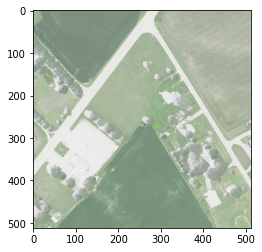

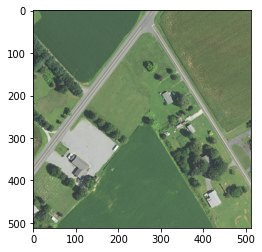

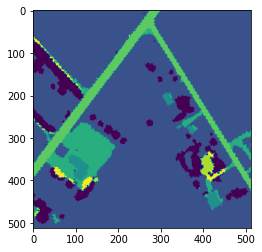

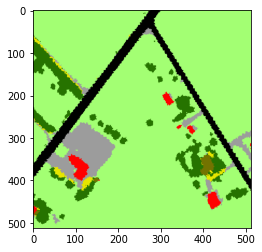

In [47]:
###############################################################################
# Exploratory data analysis
###############################################################################
# Displaying data we're working with
# I think the 4th dimension is cloud cover
sample = next(iter(dataloader))
image, target = sample["image"], sample["mask"]
print(image.shape, target.shape)
img = PIL.Image.fromarray(np.uint8(image[0].permute(1, 2, 0).numpy()))
plt.imshow(img)
plt.show()
img = PIL.Image.fromarray(np.uint8(image[0, :3].permute(1, 2, 0).numpy()))
plt.imshow(img)
plt.show()
img = PIL.Image.fromarray(np.uint8(target[0][0].numpy()))
plt.imshow(img)
plt.show()

cmap_dict = {0: (0, 0, 0, 0), 1: (0, 197, 255, 255), 2: (0, 168, 132, 255), 3: (38, 115, 0, 255), 4: (76, 230, 0, 255), 5: (163, 255, 115, 255), 6: (255, 170, 0, 255), 7: (255, 0, 0, 255), 8: (156, 156, 156, 255), 9: (0, 0, 0, 255), 10: (115, 115, 0, 255), 11: (230, 230, 0, 255), 12: (255, 255, 115, 255), 13: (197, 0, 255, 255)}
coverted = np.array([[cmap_dict[x] for x in row] for row in target[0][0].numpy()])
plt.imshow(coverted)

In [ ]:

class TestModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.embeddings = nn.Embedding()#

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layers(x)



model = 
